# Import Libraries

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, roc_auc_score

sns.set_palette(palette='Set1', n_colors=5)

# Import And Visualize Data

In [43]:
df = pd.read_csv('data/train.csv')

In [3]:
display(df.head())

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


## Understand Missing Data

In [5]:
missing_data_map = {
    'Column Name': [],
    'Missing Data Per Cent': []
}

for c in df.columns.values:
    col_series = df.loc[:, c]
    missing_data = col_series.isna().sum() / col_series.size
    missing_data_map['Column Name'].append(c)
    missing_data_map['Missing Data Per Cent'].append(round(missing_data * 100, 2))

display(pd.DataFrame(missing_data_map))

,Column Name,Missing Data Per Cent
0,PassengerId,0.00
1,HomePlanet,2.31
2,CryoSleep,2.50
3,Cabin,2.29
4,Destination,2.09
5,Age,2.06
6,VIP,2.34
7,RoomService,2.08
8,FoodCourt,2.11
9,ShoppingMall,2.39


Let's see what happens if we decide to drop the missing values:

In [7]:
display(df.shape)

df_2 = df.dropna()

display(df_2.shape)

(8693, 14)

(6606, 14)

Roughly 2000 rows will be lost, which is 25% of the data. So no data will be dropped.

Some of the columns such as `Cabin` are categorical and will be handled as such.

Numberical columns such as `RoomService` will be filled with `0` for the first analysis - the volume of missing data is very low, so imputing might not be required.

In [96]:
facilities_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

df_prep = df.copy()
df_prep[facilities_columns] = df_prep[facilities_columns].fillna(0, axis=0)
df_prep['Age'] = df['Age'].fillna(-1, axis=0)

When handling the missing cabin data, we first need to fill all missing cabin data with `NaN/-1/NaN` which denotes that the deck, number and side are missing. This then allows further processing of the data and will also allow for the data to be encoded later on.

In [97]:
cabin_split = df['Cabin'].fillna('Unknown/-1/Unknown').str.split('/')
cabin_column_arrays = np.array(cabin_split.to_numpy().T.tolist()).transpose()
df_prep['Deck_Letter'] = cabin_column_arrays[0]
df_prep['Deck_Number'] = cabin_column_arrays[1].astype('int')
df_prep['Deck_Side'] = cabin_column_arrays[2]

display(df_prep)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck_Letter,Deck_Number,Deck_Side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False,A,98,P
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False,G,1499,S
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True,G,1500,S
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False,E,608,S


In [98]:
passenger_split = df['PassengerId'].fillna('-1_-1').str.split('_')
passenger_split_arrays = np.array(passenger_split.to_numpy().T.tolist()).transpose()
df_prep['Passenger_Group'] = passenger_split_arrays[0].astype(int)
df_prep['Passenger_Group_Number'] = passenger_split_arrays[1].astype(int)

In [99]:
df_prep_2 = df_prep.drop(columns=['PassengerId', 'Cabin', 'Name'])

display(df_prep_2)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck_Letter,Deck_Number,Deck_Side,Passenger_Group,Passenger_Group_Number
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,0,P,1,1
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,0,S,2,1
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,0,S,3,1
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,0,S,3,2
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F,1,S,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,False,A,98,P,9276,1
8689,Earth,True,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,False,G,1499,S,9278,1
8690,Earth,False,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,True,G,1500,S,9279,1
8691,Europa,False,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,False,E,608,S,9280,1


In [100]:
df_prep_2['Total_Expenses'] = df[facilities_columns].sum(axis=1)

display(df_prep_2)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck_Letter,Deck_Number,Deck_Side,Passenger_Group,Passenger_Group_Number,Total_Expenses
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,0,P,1,1,0.0
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,0,S,2,1,736.0
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,0,S,3,1,10383.0
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,0,S,3,2,5176.0
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F,1,S,4,1,1091.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,False,A,98,P,9276,1,8536.0
8689,Earth,True,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,False,G,1499,S,9278,1,0.0
8690,Earth,False,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,True,G,1500,S,9279,1,1873.0
8691,Europa,False,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,False,E,608,S,9280,1,4637.0


In [101]:
categorical_columns = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck_Letter', 'Deck_Side']
df_encoded = df_prep_2.drop(columns=categorical_columns)

for col in categorical_columns:
    encoder = OneHotEncoder(handle_unknown='error')
    pclass_encoded = encoder.fit_transform(df_prep_2[[col]])
    # The results are transposed, because the original result has 891 rows with 3 elements per class.
    # However, we want to have 3 rows with all elements per class, where each row represents each class.
    pclass_encoded = pclass_encoded.transpose()

    for i, cat in enumerate(encoder.categories_[0]):
        df_encoded['%s_%s' % (col, cat)] = pclass_encoded.getrow(i).toarray()[0].astype('int')

display(df_encoded)
display(df_encoded.info())

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck_Number,Passenger_Group,Passenger_Group_Number,...,Deck_Letter_C,Deck_Letter_D,Deck_Letter_E,Deck_Letter_F,Deck_Letter_G,Deck_Letter_T,Deck_Letter_Unknown,Deck_Side_P,Deck_Side_S,Deck_Side_Unknown
0,39.0,0.0,0.0,0.0,0.0,0.0,False,0,1,1,...,0,0,0,0,0,0,0,1,0,0
1,24.0,109.0,9.0,25.0,549.0,44.0,True,0,2,1,...,0,0,0,1,0,0,0,0,1,0
2,58.0,43.0,3576.0,0.0,6715.0,49.0,False,0,3,1,...,0,0,0,0,0,0,0,0,1,0
3,33.0,0.0,1283.0,371.0,3329.0,193.0,False,0,3,2,...,0,0,0,0,0,0,0,0,1,0
4,16.0,303.0,70.0,151.0,565.0,2.0,True,1,4,1,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,41.0,0.0,6819.0,0.0,1643.0,74.0,False,98,9276,1,...,0,0,0,0,0,0,0,1,0,0
8689,18.0,0.0,0.0,0.0,0.0,0.0,False,1499,9278,1,...,0,0,0,0,1,0,0,0,1,0
8690,26.0,0.0,0.0,1872.0,1.0,0.0,True,1500,9279,1,...,0,0,0,0,1,0,0,0,1,0
8691,32.0,0.0,1049.0,0.0,353.0,3235.0,False,608,9280,1,...,0,0,1,0,0,0,0,0,1,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 37 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        8693 non-null   float64
 1   RoomService                8693 non-null   float64
 2   FoodCourt                  8693 non-null   float64
 3   ShoppingMall               8693 non-null   float64
 4   Spa                        8693 non-null   float64
 5   VRDeck                     8693 non-null   float64
 6   Transported                8693 non-null   bool   
 7   Deck_Number                8693 non-null   int64  
 8   Passenger_Group            8693 non-null   int64  
 9   Passenger_Group_Number     8693 non-null   int64  
 10  Total_Expenses             8693 non-null   float64
 11  HomePlanet_Earth           8693 non-null   int64  
 12  HomePlanet_Europa          8693 non-null   int64  
 13  HomePlanet_Mars            8693 non-null   int64

None

In [73]:
def classify(data, predict_column):
    classifier = RandomForestClassifier(n_estimators=100)
    kf = KFold(n_splits=10, random_state=100, shuffle=True)
    roc_data_arr = []
    auc_score_arr = []

    for (train, test) in kf.split(data):
        X_train = data.iloc[train].drop(columns=predict_column)
        y_train = data.loc[train, predict_column]

        X_test = data.iloc[test].drop(columns=predict_column)
        y_test = data.loc[test, predict_column]

        classifier.fit(X_train, y_train)
        prob = classifier.predict_proba(X_test).transpose()

        fpr, tpr, _ = roc_curve(y_true=y_test, y_score=prob[1])
        roc_data_arr.append((fpr, tpr))

        auc_score = round(roc_auc_score(y_test, prob[1]), 2)
        auc_score_arr.append(auc_score)

    return (roc_data_arr, auc_score_arr)

def plot_roc(roc_data_arr, auc_score_arr):
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot()
    for i, (fpr, tpr) in enumerate(roc_data_arr):
        roc_df = pd.DataFrame({'fpr': fpr, 'tpr': tpr})
        sns.lineplot(roc_df, x='fpr', y='tpr', ax=ax, label=('Fold %d: %.2f' % (i, auc_score_arr[i])), legend='full')

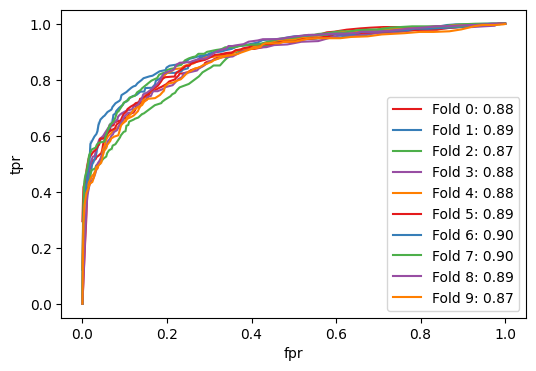

In [103]:
roc_data_arr, auc_score_arr = classify(df_encoded, 'Transported')
plot_roc(roc_data_arr, auc_score_arr)

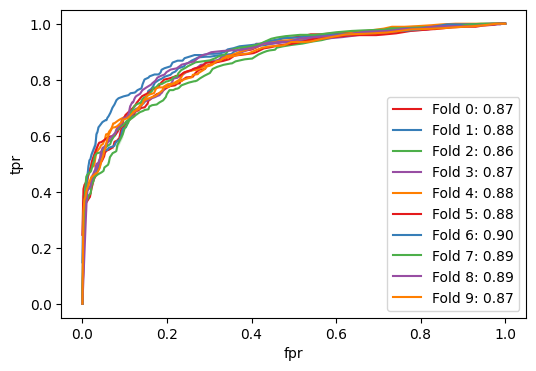

In [119]:
# 'HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck_Letter', 'Deck_Side'
    # df_encoded.filter(like='HomePlanet').columns.values.transpose().tolist() + \
columns_to_drop = ['Passenger_Group', 'Passenger_Group_Number'] + \
    df_encoded.filter(like='Destination').columns.values.transpose().tolist()
df_encoded_2 = df_encoded.drop(columns=columns_to_drop)

roc_data_arr, auc_score_arr = classify(df_encoded_2, 'Transported')
plot_roc(roc_data_arr, auc_score_arr)